In [1]:
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import Model
import matplotlib.pyplot as plt


In [3]:
def transform(sample):
    #Cluster number: 2
    return tf.stack([tf.cast(tf.math.sign(sample[:,0]), tf.float32)*tf.abs(sample[:,0])**0.2*5+sample[:,0], sample[:,1]], axis=1)
    #return tf.stack([sample[:,1], tf.cast(tf.math.sign(sample[:,0]), tf.float32)+sample[:,0]], axis=1)
    #return tf.stack([sample[:,0], tf.cast(tf.math.sign(sample[:,1]), tf.float32)+sample[:,1]], axis=1)



In [4]:
x_size=2
z_size=2
mapping=False

Vamp=False
Vamp_input_num=10 #!

class coder(Model):
    def __init__(self, output_size, transform=None):
        super(coder, self).__init__()
        self.d1 = tf.keras.layers.Dense(10, activation='relu')
        self.d2 = tf.keras.layers.Dense(10, activation='relu')
        self.d3 = tf.keras.layers.Dense(output_size*2, activation=None)
        self.transform=transform

    def call(self, x):
        if self.transform:
            x = self.transform(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

encoder = coder(z_size)
if mapping:
    decoder = coder(x_size, transform=transform)
else:
    decoder = coder(x_size, transform=None)

In [5]:
def logsumexp(x, axis=-1):
    x_max=tf.reduce_max(x, axis=axis, keepdims=True)
    x-=x_max
    x_exp=tf.exp(x)
    x_exp_mean=tf.reduce_sum(x_exp, axis=axis)
    x_exp_mean_log=tf.math.log(x_exp_mean)+tf.squeeze(x_max, axis=-1)
    return x_exp_mean_log
def logmeanexp(x, axis=-1):
    return logsumexp(x, axis=axis)-tf.math.log(float(x.shape[axis]))

In [6]:
def logP_MoG(x, mean, log_var):
    x=tf.expand_dims(x, 1)
    mean=tf.expand_dims(mean, 0)
    log_var=tf.expand_dims(log_var, 0)
    logP_component_dim=-np.log(2*np.pi)/2-log_var/2-(x-mean)**2/(2*tf.exp(log_var))
    logP_component=tf.reduce_sum(logP_component_dim, axis=-1)
    #P_component=tf.exp(logP_component)
    #P=tf.reduce_mean(P_component, axis=-1)
    #logP=tf.math.log(P)
    logP=logmeanexp(logP_component, axis=-1)
    return logP

In [7]:
if Vamp:
    initial_value=np.random.normal(0,1,[Vamp_input_num, x_size]).astype(np.float32)
    pseduo_input=tf.Variable(initial_value=initial_value, dtype=tf.float32)

In [8]:
optimizer = tf.keras.optimizers.Adam()
reconstruction_logprob_record = tf.keras.metrics.Mean(name='reconstruction')
KL_term_record = tf.keras.metrics.Mean(name='KL')
ELBO_record = tf.keras.metrics.Mean(name='ELBO')

def sample(mean, log_var):
    batch = tf.shape(mean)[0]
    dim = tf.shape(mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mean + tf.exp(0.5 * log_var) * epsilon
    
def reconstruction_logprob(x, x_mean, x_log_var):
    dim = tf.shape(x)[1]
    return -tf.cast(dim, tf.float32)*0.5*(tf.math.log(2.0*np.pi)+tf.reduce_sum(x_log_var, axis=1))-0.5*tf.reduce_sum((x-x_mean)**2*tf.exp(-x_log_var), axis=1)

def KL_term(mean_1, log_var_1, mean_2, log_var_2):
    dim_KL = 0.5*(log_var_2-log_var_1)+(tf.exp(log_var_1)+(mean_1-mean_2)**2)/(2*tf.exp(log_var_2))-0.5
    return tf.reduce_sum(dim_KL, axis=1)

@tf.function
def train_step(x, beta=1e-7, test=False): #!
    with tf.GradientTape() as tape:
        z_x_info = encoder(x)
        z_x_mean=z_x_info[:,:z_size]
        z_x_log_var=z_x_info[:,z_size:]
        z_sample=sample(z_x_mean, z_x_log_var)
        x_z_info=decoder(z_sample)
        x_z_mean=x_z_info[:,:x_size]
        x_z_log_var=x_z_info[:,x_size:]
        reconstruction_logprob_0=tf.reduce_mean(reconstruction_logprob(x, x_z_mean, x_z_log_var))
        
        if not Vamp:
            KL_term_0=tf.reduce_mean(KL_term(z_x_mean, z_x_log_var, z_x_mean*0, z_x_log_var*0+1))
            
            #logQ = reconstruction_logprob(z_sample, z_x_mean, z_x_log_var)
            #logP = logP_MoG(z_sample, z_sample[0:1]*0, z_sample[0:1]*0)
            #logP = log_normal_pdf(z_sample, z_sample*0, z_sample*0)
            
            #KL_term_0 = tf.reduce_mean(logQ-logP)
        
        else:
            pseduo_z_x_info = encoder(pseduo_input)
            pseduo_z_x_mean = pseduo_z_x_info[:,:z_size]
            pseduo_z_x_log_var = pseduo_z_x_info[:,z_size:]
            #pseduo_z_x_mean = pseduo_z_x_info[0:1,:z_size] #!
            #pseduo_z_x_log_var =pseduo_z_x_info[0:1,:z_size] #!
            logQ = reconstruction_logprob(z_sample, z_x_mean, z_x_log_var)
            logP = logP_MoG(z_sample, pseduo_z_x_mean, pseduo_z_x_log_var)
            KL_term_0 = tf.reduce_mean(logQ-logP) ##Problem here
        
        gain = reconstruction_logprob_0 - KL_term_0*beta
        loss = -gain
    if not test:
        trainable_variables=encoder.trainable_variables+decoder.trainable_variables
        if Vamp:
            trainable_variables.append(pseduo_input)
        gradients = tape.gradient(loss, trainable_variables)
        
        optimizer.apply_gradients(zip(gradients, trainable_variables))

    reconstruction_logprob_record(reconstruction_logprob_0)
    KL_term_record(KL_term_0)
    ELBO_record(gain)

FileNotFoundError: [Errno 2] No such file or directory: 'figure/MoG_real.png'

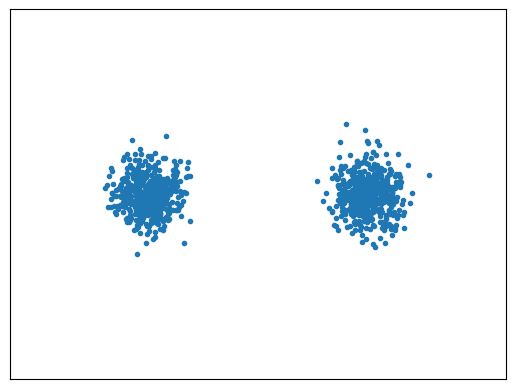

In [9]:
transform_mat_45=np.array([[2**0.5, 2**0.5],[2**-0.5, -2**-0.5]]).astype(np.float32)
transform_mat_0=np.array([[1.0, 0.0],[0.0, 1.0]]).astype(np.float32)
transform_mat_1_dim=np.array([[1, 0],[0, 0.01]]).astype(np.float32)


def data_generation_Gaussian(batch_size=10, transform_mat=transform_mat_0):
    Gaussian=np.random.normal(0, 1, [batch_size, 2]).astype(np.float32)
    return np.dot(Gaussian, transform_mat)

def data_generation_uniform(batch_size=10, dim=2):
    Uniform=np.random.uniform(-1,1,[batch_size, dim]).astype(np.float32)*2**0.5
    return Uniform

def data_generation_circle(batch_size=1, portion=1):
    r=np.random.uniform(0, 2*np.pi*portion, [batch_size])
    
    Circle_cos=np.cos(r)
    Circle_sin=np.sin(r)
    Circle=np.stack([Circle_cos,Circle_sin], axis=1).astype(np.float32)*2
    return Circle

def data_generation_MoG(batch_size=10):
    Gaussian_1=np.random.normal(0, 0.3, [int(batch_size/2), 2]).astype(np.float32)
    Gaussian_1[:,0]-=2
    Gaussian_2=np.random.normal(0, 0.3, [int(batch_size/2), 2]).astype(np.float32)
    Gaussian_2[:,0]+=2
    return np.concatenate([Gaussian_1, Gaussian_2])

def data_generation(batch_size=10, seed=0):
    if seed!=0:
        np.random.seed(seed)
    return data_generation_MoG(batch_size=batch_size)
    #return data_generation_Gaussian(batch_size=batch_size)

X_data=data_generation(1000)
fig = plt.figure(frameon=False)
plt.plot(X_data[:,0], X_data[:,1], '.')
plt.axis([-4.5,4.5, -3, 3])
plt.xticks([])
plt.yticks([])
fig.savefig('figure/MoG_real.png', bbox_inches = 'tight',
    pad_inches = 0) #!


In [10]:
logP_record = tf.keras.metrics.Mean(name='logP')

def reparameterize_multi(mean, logvar, num=10):
    shape=mean.shape
    shape_new=[mean.shape[0], num]
    for i in range(1, len(shape)):
        shape_new.append(shape[i])
    eps = tf.random.normal(shape=shape_new)   
    return eps * tf.exp(tf.expand_dims(logvar, axis=1) * .5) + tf.expand_dims(mean, axis=1)
    
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_log_P(x, num=10):
    x_shape = x.shape
    z_x_info = encoder(x)
    mean=z_x_info[:,:z_size]
    logvar=z_x_info[:,z_size:]

    z = reparameterize_multi(mean, logvar, num)
    mean_multi=tf.tile(tf.expand_dims(mean, axis=1), multiples=[1,num,1])
    log_var_multi=tf.tile(tf.expand_dims(logvar, axis=1), multiples=[1,num,1])
    z_logprob_in_log_z_x=log_normal_pdf(z, mean_multi, log_var_multi, raxis=-1)
    
    if not Vamp:
        z_logprob_in_log_z=log_normal_pdf(z, mean_multi*0, log_var_multi*0, raxis=-1)
    else:
        pseduo_z_x_info = encoder(pseduo_input)
        pseduo_z_x_mean = pseduo_z_x_info[:,:z_size]
        pseduo_z_x_log_var = pseduo_z_x_info[:,z_size:]
        z_reshape=tf.reshape(z, [-1,z_size])
        
        z_logprob_in_log_z=logP_MoG(z_reshape, pseduo_z_x_mean, pseduo_z_x_log_var)
        z_logprob_in_log_z=tf.reshape(z_logprob_in_log_z, [-1, num])
    
    logratio=z_logprob_in_log_z-z_logprob_in_log_z_x

    z_reshape = tf.reshape(z, [-1, z.shape[-1]])
                    
    x_z_info=decoder(z_reshape)
    x_z_mean=x_z_info[:,:x_size]
    x_z_logvar=x_z_info[:,x_size:]
    x_z_mean=tf.reshape(x_z_mean, [-1, num, x_shape[1]])
    x_z_logvar=tf.reshape(x_z_logvar, [-1, num, x_shape[1]])
    
    x_multi=tf.tile(tf.expand_dims(x,1),multiples=[1,num,1])
    logP_x_z=log_normal_pdf(x_multi, x_z_mean, x_z_logvar, raxis=-1)
    logP_pre=logP_x_z+logratio
    logP_pre_max=tf.reduce_max(logP_pre, axis=1)
    logP_pre_sub=logP_pre-tf.expand_dims(logP_pre_max, axis=1)
    logP_x=tf.math.log(tf.reduce_mean(tf.exp(logP_pre_sub), axis=1))+logP_pre_max
    logP_record(logP_x)

def logP_epoch(data_generation_function, num, sample_size):
    logP_record.reset_states()
    i=0
    while True:
        test_x=data_generation_function(batch_size=10, seed=101)
        compute_log_P(test_x, num)
        i+=test_x.shape[0]
        if i>=sample_size:
            break
    return logP_record.result().numpy()
logP_epoch(data_generation, 500, 2000)

-3.85796

In [11]:
EPOCHS = 2000
beta=1
for epoch in range(EPOCHS):
    reconstruction_logprob_record.reset_states()
    KL_term_record.reset_states()
    ELBO_record.reset_states()

    for i in range(10):    
        X_data=data_generation()
        train_step(X_data, beta=beta)

    template = 'Epoch {}, ELBO:{}, reconstruct: {}, KL: {}'
    if epoch%100==0:
        print (template.format(epoch+1,
                          ELBO_record.result(), 
                          reconstruction_logprob_record.result(),
                          KL_term_record.result()))

Epoch 1, ELBO:-4.40833044052124, reconstruct: -3.984978199005127, KL: 0.42335277795791626
Epoch 101, ELBO:-0.3369974195957184, reconstruct: 1.1374232769012451, KL: 1.4744206666946411
Epoch 201, ELBO:0.8563457727432251, reconstruct: 3.1326215267181396, KL: 2.276275873184204
Epoch 301, ELBO:1.3319615125656128, reconstruct: 4.0331130027771, KL: 2.7011516094207764
Epoch 401, ELBO:1.0191900730133057, reconstruct: 3.978713274002075, KL: 2.9595229625701904
Epoch 501, ELBO:2.20698881149292, reconstruct: 5.586716651916504, KL: 3.379727840423584
Epoch 601, ELBO:2.418099880218506, reconstruct: 6.002930641174316, KL: 3.5848305225372314
Epoch 701, ELBO:2.761425495147705, reconstruct: 6.945574760437012, KL: 4.184149265289307
Epoch 801, ELBO:3.2679443359375, reconstruct: 8.079511642456055, KL: 4.811566352844238
Epoch 901, ELBO:3.3184380531311035, reconstruct: 8.406946182250977, KL: 5.088507175445557
Epoch 1001, ELBO:3.4619929790496826, reconstruct: 9.062516212463379, KL: 5.600522041320801


In [ ]:
logP_epoch(data_generation, 500, 2000)

In [ ]:
def generate_from_MoG(batch_size, mean, log_var):
    samples=[]
    batch_size_each_component=batch_size//mean.shape[0]
    for i in range(mean.shape[0]):
        sample=np.random.normal(0, 1, [batch_size_each_component, mean.shape[1]]).astype(np.float32)
        sample=sample*np.exp(log_var[i]*0.5)+mean[i]
        samples.append(sample)
    samples=np.concatenate(samples, axis=0)
    return samples

In [ ]:
if not Vamp:
    Z_data=data_generation_Gaussian(200, transform_mat=transform_mat_0)
else:
    pseduo_z_x_info = encoder(pseduo_input)
    pseduo_z_x_mean = pseduo_z_x_info[:,:z_size]
    pseduo_z_x_log_var = pseduo_z_x_info[:,z_size:]
    Z_data=generate_from_MoG(200, pseduo_z_x_mean, pseduo_z_x_log_var)
x_z_info = decoder(Z_data)
x_z_mean=x_z_info[:,:x_size]
x_z_log_var=x_z_info[:,x_size:]
x_z_std=np.exp(x_z_log_var/2)
samples=sample(x_z_mean, x_z_log_var)

fig = plt.figure(frameon=False)
plt.plot(samples[:,0], samples[:,1], '.')
plt.axis([-4.5,4.5, -3, 3])
plt.xticks([])
plt.yticks([])
#fig.savefig('figure/cluster_vamp.pdf', bbox_inches = 'tight',
#    pad_inches = 0)

In [ ]:
print("Shweta has run the code")